## beat-based manual segmentation


In [1]:
import os
import pretty_midi
import midi_utils as mu
from pathlib import Path
import matplotlib.pyplot as plt

plt.style.use("dark_background")

### quantization based on beat


In [2]:
def calculate_beat_times(bpm, total_length_seconds):
  """
  Calculate the timing of each beat in a MIDI file based on its total length.

  Args:
  bpm (float): Beats per minute of the MIDI file.
  total_length_seconds (float): Total length of the MIDI clip in seconds.

  Returns:
  list: A list containing the time of each beat in seconds.
  """
  beat_duration = 60.0 / bpm
  total_beats = int(bpm * total_length_seconds / 60)
  return [beat_duration * beat for beat in range(total_beats + 1)]


In [14]:
def split_midi(midi_file_path, beats_per_segment, output_folder):
  """
  Splits a MIDI file into segments based on the given beat timings and number of beats per segment.

  Args:
  :param midi_file_path: Path to the MIDI file.
  :param actual_tempo: The actual tempo (BPM) of the MIDI file.
  :param beat_timings: List of beat timings at the given tempo.
  :param beats_per_segment: Number of beats in each segment.
  :param output_folder: Folder to save the split MIDI files.

  Returns:
  list (pretty_midi.PrettyMIDI): All of the generated segments.
  """
  # Load MIDI file
  filename = Path(midi_file_path).stem
  midi_data = pretty_midi.PrettyMIDI(midi_file_path)
  
  # Calculate segment start and end times
  beat_times = calculate_beat_times(120, midi_data.get_end_time())
  segment_times = [(beat_times[i], beat_times[min(i + beats_per_segment, len(beat_times) - 1)])
                    for i in range(0, len(beat_times), beats_per_segment)]

  segments = []
  for i, (start_time, end_time) in enumerate(segment_times):
    if round(start_time) == round(end_time):
      continue
    # Create a new MIDI object for each segment
    segment_midi = pretty_midi.PrettyMIDI()
    output_filename = f'{filename}_{round(start_time):03d}-{round(end_time):03d}.mid'

    # Adjust notes for each instrument
    for instrument in midi_data.instruments:
      segment_instrument = pretty_midi.Instrument(program=instrument.program, is_drum=instrument.is_drum, name=output_filename)
      for note in instrument.notes:
        if start_time <= note.start < end_time:
          new_note = pretty_midi.Note(
            velocity=note.velocity,
            pitch=note.pitch,
            start=note.start - start_time,
            end=min(note.end, end_time) - start_time
          )
          segment_instrument.notes.append(new_note)
      segment_midi.instruments.append(segment_instrument)

    # Save the segment
    segments.append((output_filename, segment_midi))
    segment_file_path = os.path.join(output_folder, output_filename)
    segment_midi.write(segment_file_path)
    print(f"\tLoop {i + 1:03d} ({start_time:05.1f}s to {end_time:05.1f}s) --> {segment_midi.get_piano_roll().shape} saved to {segment_file_path}")

  return segments

### beat visualization test


In [4]:
import numpy as np

def add_zero_columns(array, num_columns):
    """
    Add columns of zeros to the end of an array until it has the specified number of columns.

    :param array: Input numpy array.
    :param num_columns: The desired number of columns.
    :return: The modified array with added zero columns.
    """
    current_rows, current_columns = array.shape
    columns_to_add = num_columns - current_columns
    if columns_to_add > 0:
        zeros = np.zeros((current_rows, columns_to_add))

        return np.hstack((array, zeros))
    else:
        return array


In [15]:
midi_folder = os.path.join("data", "trimmed outputs")
dir_out = os.path.join("data", "beats")
segs = 8
fs = 100

for i, filename in enumerate(os.listdir(midi_folder)):
  midi_file = os.path.join(midi_folder, filename)
  tempo = Path(filename).stem.split('-')[1]
  print(f"[{i:02d}] Segmenting {filename} with tempo {tempo}")
  segments = split_midi(midi_file, segs, dir_out)

  for j, (name, segment) in enumerate(segments):
    piano_roll = segment.get_piano_roll(fs) # TODO APPLY DOWNSAMPLING HERE?
    # TODO CALCULATE DELTA T HERE
    print(f"\033[32m[{j:02d}]\tGenerated segment {name} --> {piano_roll.shape}\033[0m")
    piano_roll = add_zero_columns(piano_roll, 400)[22:80] / 127
    print(f"\033\t\tDownsampled to {piano_roll.shape}\033[0m")
    # TODO OR APPLY DOWNSAMPLING HERE?
    # TODO ADD DELTA T COLUMN HERE WITH HSTACK


[00] Segmenting 20240121-66-2-t.mid with tempo 66
	Loop 001 (000.0s to 004.0s) --> (128, 389) saved to data/beats/20240121-66-2-t_000-004.mid
	Loop 002 (004.0s to 008.0s) --> (128, 386) saved to data/beats/20240121-66-2-t_004-008.mid
	Loop 003 (008.0s to 012.0s) --> (128, 385) saved to data/beats/20240121-66-2-t_008-012.mid
	Loop 004 (012.0s to 016.0s) --> (128, 384) saved to data/beats/20240121-66-2-t_012-016.mid
	Loop 005 (016.0s to 020.0s) --> (128, 382) saved to data/beats/20240121-66-2-t_016-020.mid
	Loop 006 (020.0s to 024.0s) --> (128, 389) saved to data/beats/20240121-66-2-t_020-024.mid
	Loop 007 (024.0s to 028.0s) --> (128, 385) saved to data/beats/20240121-66-2-t_024-028.mid
	Loop 008 (028.0s to 032.0s) --> (128, 387) saved to data/beats/20240121-66-2-t_028-032.mid
	Loop 009 (032.0s to 035.5s) --> (128, 346) saved to data/beats/20240121-66-2-t_032-036.mid
[00]	Generated segment 20240121-66-2-t_000-004.mid --> (128, 389)
[01]	Generated segment 20240121-66-2-t_004-008.mid --> (

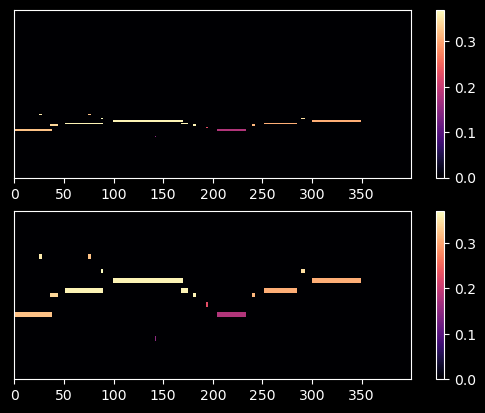

In [18]:
# plot
# plt.subplot(2, 1, 1)
# plt.yticks([])
# plt.imshow(mu.trim_piano_roll(piano_roll), aspect='auto', origin='lower', cmap='magma', interpolation='nearest')
# for i, beat in enumerate(beats):
#     plt.axvline(x=beat * fs, color='r' if i % segs == 0 else 'g')

# plt.subplot(2, 2, 3)
# plt.yticks([])
# plt.imshow(mu.trim_piano_roll(segments[0].get_piano_roll()), aspect='auto', origin='lower', cmap='magma', interpolation='nearest')
    
# plt.subplot(2, 2, 4)
# plt.yticks([])
# plt.imshow(mu.trim_piano_roll(segments[1].get_piano_roll()), aspect='auto', origin='lower', cmap='magma', interpolation='nearest')
# plt.show()

# plt.subplot(2, 1, 1)
# plt.yticks([])
# plt.imshow(piano_roll, aspect='auto', origin='lower', cmap='magma', interpolation='nearest')
# plt.colorbar()
# plt.subplot(2, 1, 2)
# plt.yticks([])
# plt.imshow(piano_roll[23:58], aspect='auto', origin='lower', cmap='magma', interpolation='nearest')
# plt.colorbar()
# plt.show()

## Visualizing Quantization Effects


In [ ]:
midi_folder = os.path.join("data", "time", "20231220-80-1-t", "20231220-80-1-t_0-8.mid")
dir_out = os.path.join("data", "beats")
tempo = 80
subds = 12

fpr= pretty_midi.PrettyMIDI(midi_folder)
qpr = mu.quantize_midi(midi_folder, subds)

qpr.write(os.path.join("data", "beats-quantized", "20231220-80-1-tq_0-8.mid"))

plt.subplot(2, 1, 1)
plt.yticks([])
plt.imshow(mu.trim_piano_roll(qpr.get_piano_roll()), aspect='auto', origin='lower', cmap='magma', interpolation='nearest')
plt.subplot(2, 1, 2)
plt.yticks([])
plt.imshow(mu.trim_piano_roll(fpr.get_piano_roll(fs=round(1/(60/(tempo * subds))))), aspect='auto', origin='lower', cmap='magma', interpolation='nearest')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'data/beats-quantized/20231220-80-1-tq_0-8.mid'

### Actually segment, then generate


In [ ]:
bs_path = os.path.join("data", "beats")
all_in_path = os.path.join("data", "trimmed outputs")
segments = []

for file in os.listdir(all_in_path):
  segments.append(split_midi_into_beats(os.path.join(all_in_path, file), bs_path, 8))

segments_flat = [segment for segmentss in segments for segment in segmentss]
target_len = round(segments_flat[0].get_piano_roll().shape[1]/100)*100
for segment in segments_flat:
  seg_shape = segment.get_piano_roll().shape
  if seg_shape[1] != target_len:
    print(f"{segment.instruments[0].name} has bad length {seg_shape} (wanted {target_len})")
print(f"generated {len(segments_flat)} segments")

[0.0, 0.9090909090909091, 1.8181818181818181, 2.727272727272727, 3.6363636363636362, 4.545454545454545, 5.454545454545454, 6.363636363636363, 7.2727272727272725, 8.181818181818182, 9.09090909090909, 10.0, 10.909090909090908, 11.818181818181818, 12.727272727272727, 13.636363636363637, 14.545454545454545, 15.454545454545453, 16.363636363636363, 17.272727272727273, 18.18181818181818, 19.09090909090909, 20.0, 20.90909090909091, 21.818181818181817, 22.727272727272727, 23.636363636363637, 24.545454545454543, 25.454545454545453, 26.363636363636363, 27.272727272727273, 28.18181818181818, 29.09090909090909, 30.0, 30.909090909090907, 31.818181818181817, 32.72727272727273, 33.63636363636363, 34.54545454545455]
segment 0 start 0.0 end 7.2727272727272725
segment 8 start 7.2727272727272725 end 14.545454545454545
segment 16 start 14.545454545454545 end 21.818181818181817
segment 24 start 21.818181818181817 end 29.09090909090909
segment 32 start 29.09090909090909 end 35.84375
split 20240121-66-2-t int